# Homework 4

### Nick Tyler

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from re import match
pd.options.mode.chained_assignment = None

In [3]:
'''
This function iterates through the column of
the dataframe that is passed in and specified
and turns any range of numbers into an average
of the numbers in that range. For values that use
greater than or less than, the range becomes the number 
given, and then either 0 or 100 depending on the sign (<,>)
'''
def unblurr_col(dframe, colname):
    rgx = '([a-zA-Z]*)(\d*)(-*)(\d*)'
    col_data = dframe[[colname]].copy()
    for i in range(len(col_data)):
        val = col_data.iloc[i][0]
        mobj = match(rgx, val)
        
        ltgt, num1, hyph, num2 = mobj.groups()
        num1 = int(num1)
        if ltgt in ['LT', 'LE']:
            num2 = 0
        elif ltgt in ['GT', 'GE']:
            num2 = 100
        elif num2 == '':
            num2 = num1
        else:
            num2 = int(num2)
        final_num = round((num1 + num2) / 2)
        col_data.iloc[i][0] = final_num
    dframe[colname] = col_data

In [47]:
fiscal_data = pd.read_csv('./data/Sdf16_1a.txt', sep='\t')
fiscal_data['LEAID'] = fiscal_data['LEAID'].astype(str)
math_data = pd.read_csv('./data/math_data.csv')
math_data['LEAID'] = math_data['LEAID'].astype(str)
all_data = pd.merge(fiscal_data, math_data, on='LEAID')
race_data = pd.read_csv('./data/race_data.csv')
race_data['LEAID'] = race_data['LEAID'].astype(str)
race_data = race_data[['LEAID', 'TOTAL', 'AM', 'AS', 
           'HI', 'BL', 'WH', 'HP', 'TR']]
race_data = race_data[race_data['TOTAL'] > 0]
race_data = race_data[race_data['HP'] >= 0]

disab_data = pd.read_csv('./data/disab_data.csv')
disab_data['LEAID'] = disab_data['LEAID'].astype(str)
disab_data = pd.merge(disab_data, race_data, on='LEAID')
disab_data = disab_data[disab_data['TOTAL'] > 0]
disab_data = disab_data[disab_data['SPECED'] >= 0]
disab_data['SPECED'] = disab_data['SPECED'] / disab_data['TOTAL']
for column in ['AM', 'AS', 'HI', 'BL', 'WH', 'HP', 'TR']:
    race_data[column] = race_data[column] / race_data['TOTAL']

/home/nick/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/nick/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/nick/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Problem 1

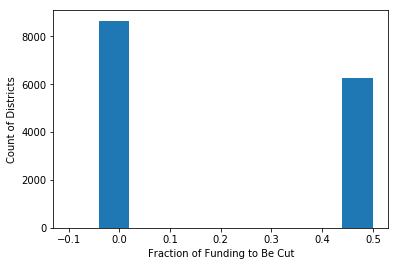

In [32]:
budget = fiscal_data.query('TFEDREV>0')['TFEDREV'].values.sum()
budget = int(round(.15 * budget))
cut_data = all_data.query('ALL_MTH00PCTPROF_1516!=\'PS\'')
unblurr_col(cut_data, 'ALL_MTH00PCTPROF_1516')
median_score = int(cut_data['ALL_MTH00PCTPROF_1516'].median())
cutoff = median_score + 5
tot_rev_outperf = cut_data.query(
    'ALL_MTH00PCTPROF_1516>' + str(cutoff)
)['TFEDREV'].sum()
cut_perc = budget / tot_rev_outperf
cut_data['TOCUT'] = cut_data['TFEDREV']
cut_data.loc[cut_data['ALL_MTH00PCTPROF_1516'] <= cutoff, 'TOCUT'] = 0
cut_data.loc[
    cut_data['ALL_MTH00PCTPROF_1516'] > cutoff, 'TOCUT'
] = cut_data.loc[
    cut_data['ALL_MTH00PCTPROF_1516'] > cutoff, 'TOCUT'
].copy() * (cut_perc)
cut_data['CUTPERC'] = cut_data['TOCUT'] / cut_data['TFEDREV']
cut_percents = cut_data['CUTPERC'].values
cut_percents = cut_percents[~np.isnan(cut_percents)]
plt.hist(cut_percents, bins=10, range=(-.1, .5))
plt.xlabel("Fraction of Funding to Be Cut")
plt.ylabel("Count of Districts")
plt.show()

The districts that are most affected by my proposed cuts are the ones which scored more than 5% higher than the median school in terms of percentage of students achieving proficiency on mathematics exams. All schools who reached this bucket received around a 45% cut with all other schools getting a 0% cut.

## Problem 2

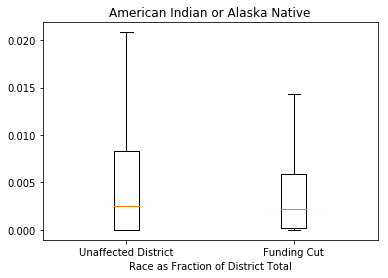

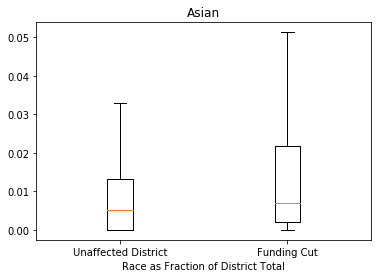

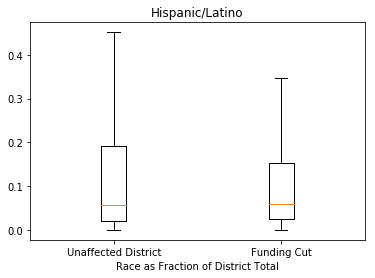

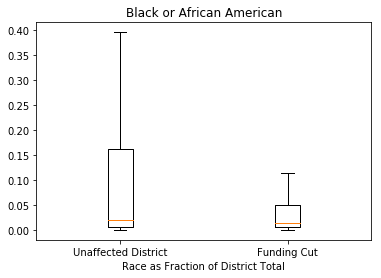

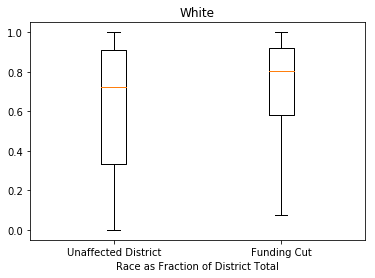

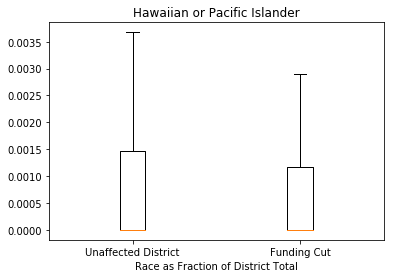

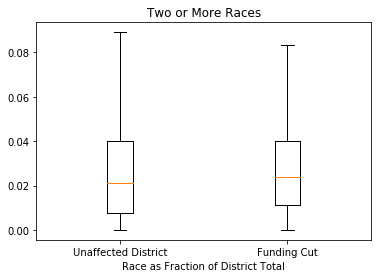

In [36]:
race_map = {
    'AM': 'American Indian or Alaska Native',
    'AS': 'Asian',
    'BL': 'Black or African American',
    'HI': 'Hispanic/Latino',
    'WH': 'White',
    'HP': 'Hawaiian or Pacific Islander',
    'TR': 'Two or More Races'
}
race_cuts = pd.merge(race_data, cut_data, on='LEAID')
cut_leis = race_cuts[race_cuts['CUTPERC'] > 0]
non_cut_leis = race_cuts[race_cuts['CUTPERC'] == 0]
for column in ['AM', 'AS', 'HI', 'BL', 'WH', 'HP', 'TR']:
    fig, ax = plt.subplots()
    ax.boxplot([non_cut_leis[column], 
                cut_leis[column]], 
               showfliers=False)
    ax.set_xticklabels(["Unaffected District", "Funding Cut"])
    plt.title(race_map[column])
    plt.xlabel("Race as Fraction of District Total")
    plt.show()

Overall it appears that my cuts have disproportionately affected white and asian students. For all races except for white and asian, the distribution of racial makup for each district tends to be towards the higher side in the unaffected box, and lower in the funding cut box. This implies that races other than white and asian were underrepresented in the schools that had their funding cut. White and asian children were the opposite and were overrepresented in schools that had their funding cut.

## Problem 3

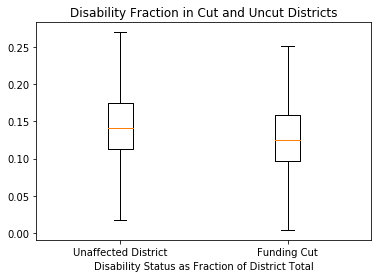

In [46]:
disab_cuts = pd.merge(disab_data, cut_data, on='LEAID')
cut_leis = disab_cuts[disab_cuts['CUTPERC'] > 0]
non_cut_leis = disab_cuts[disab_cuts['CUTPERC'] == 0]
for column in ['SPECED']:
    fig, ax = plt.subplots()
    ax.boxplot([non_cut_leis[column], 
                cut_leis[column]], 
               showfliers=False)
    ax.set_xticklabels(["Unaffected District", "Funding Cut"])
    plt.title("Disability Fraction in Cut and Uncut Districts")
    plt.xlabel("Disability Status as Fraction of District Total")
    plt.show()

The distributions of students who are members of IDEA for districts with and without their funding cut are relatively similar. These students are likely slightly underrepresented in districts with their funding cut although the differences are very small. It is likely that overall the differences in distributions wouldn't be considered to be biased, although there is a small amount of evidence the funding cuts overly affected districts with smaller numbers of IDEA students.

## Problem 4

Link to Solution: https://github.com/zferic/DS5500-Homework3

There are some clear advantages to the method described in problem 5 in the solution from HW3 above. To start, one advantage of this method is that it is a progressive system where the higher performing a school is, the more its funding gets cut. The idea behind this is likely that high performing schools need the funding less because they are already doing well. Another advantage to this method is that this method is extendable to future years when the budget needs to be cut or rebalanced. It is entirely possible to imagine a system where this is run anually and the system of schools reaches a level of stasis after a number of years where the spread of scores on tests is smaller and lower performing schools perform better.

However, the main drawback to this method is that test scores may not be a good metric to base cuts on as it is likely that a large portion of federal funding is spent on programs outside of improving test scores such as music programs or school clubs. It probable that test scores and funding are not perfectly correlated and this method would result in reduced funding for schools that score strongly on tests for reasons outside of funding. This would mean that if a district happens to have particularly good teachers, the schools funding may be cut and it would have less outside activities, essentially penalizing extra-curricular activities because the school has excellent teachers.

## Problem 5


**Visualization Lecture**

Additional steps should be taken when considering and deciding on how to best visualize data. Often times less is more when making a visualization, and adding onto a relatively simple figure can actually decrease its readability. 

Consideration of color is also an important feature of a good visualization. Different colors that are on a computer scale are not linearly percieved by humans. When creating a figure with a color gradient, it is important to use a gradient that is evenly distributed in the eyes of a human, rather than one that is evenly distributed by hex code. Considerations should also be given for people with color blindness. It is likely that figures that have colors that were arbitrarily selected could give people with color blindness issues and reduce the understandability of the figure.

Lastly, it is important to create your figures in such a way that the story the data conveys is accurately told. It is very easy to convey an invalid conclusion with a poorly designed figure. It is also possible that a figure alone may not be useful, but when accompanied by another figure or by human explaination, it becomes a strong part of the story. Figures should be disigned with the context that they will be consumed in considered.

Overall I found this to be an extremely useful lecture. Personally I had little experience with visualization outside of the classroom and many of the concepts discussed in the lecture were very new to me. A lot of the concepts are actually quite easily to apply once you take them into consideration, and I felt that this lecture will contribute to my ability to present and convey concepts in the future.